Sieć perceptronowa - nasz

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, Flatten, Input, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping

# Ustawienie stylu wykresów
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# ---- WCZYTYWANIE ----
# Upewnij się, że plik jest w tym samym folderze
data = pd.read_csv("XAU_1d_data.csv", delimiter=";")
data["Date"] = pd.to_datetime(data["Date"])
data = data.sort_values("Date")

# Feature Engineering
data["Target"] = data["Close"].shift(-1)
data = data.dropna()

features = ["Open", "High", "Low", "Volume", "Close"]
X_raw = data[features].values
y_raw = data["Target"].values.reshape(-1, 1)

# ---- PODZIAŁ (70%, 15%, 15%) ----
n = len(X_raw)
train_idx = int(n * 0.7)
val_idx = int(n * 0.85)

X_train_raw, y_train_raw = X_raw[:train_idx], y_raw[:train_idx]
X_val_raw, y_val_raw = X_raw[train_idx:val_idx], y_raw[train_idx:val_idx]
X_test_raw, y_test_raw = X_raw[val_idx:], y_raw[val_idx:]

# ---- SKALOWANIE ----
scaler_x = StandardScaler().fit(X_train_raw)
scaler_y = StandardScaler().fit(y_train_raw)

X_train, y_train = scaler_x.transform(X_train_raw), scaler_y.transform(y_train_raw)
X_val, y_val = scaler_x.transform(X_val_raw), scaler_y.transform(y_val_raw)
X_test, y_test = scaler_x.transform(X_test_raw), scaler_y.transform(y_test_raw)

# ---- SEKWENCJE DLA CNN/LSTM ----
TIME_STEPS = 7


def create_sequences(X, y, time_steps=7):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i : (i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


# Fix na "dziury" w danych (Data Leakage Prevention / Continuity)
# Pobieramy końcówkę treningu do walidacji i końcówkę walidacji do testu
# żeby pierwsze dni walidacji/testu miały z czego czerpać historię.
X_val_with_lookback = np.concatenate((X_train[-TIME_STEPS:], X_val))
y_val_with_lookback = np.concatenate((y_train[-TIME_STEPS:], y_val))

X_test_with_lookback = np.concatenate((X_val[-TIME_STEPS:], X_test))
y_test_with_lookback = np.concatenate((y_val[-TIME_STEPS:], y_test))

# Tworzenie sekwencji
X_train_seq, y_train_seq = create_sequences(X_train, y_train, TIME_STEPS)
X_val_seq, y_val_seq = create_sequences(
    X_val_with_lookback, y_val_with_lookback, TIME_STEPS
)
X_test_seq, y_test_seq = create_sequences(
    X_test_with_lookback, y_test_with_lookback, TIME_STEPS
)

print(f"Dane XAU gotowe.")
print(f"Train shapes: {X_train_seq.shape}")
print(f"Val shapes:   {X_val_seq.shape}")
print(f"Test shapes:  {X_test_seq.shape}")

Dane XAU gotowe.
Train shapes: (3815, 7, 5)
Val shapes:   (819, 7, 5)
Test shapes:  (820, 7, 5)


/home/sebastian/Studia/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
class CustomMLPRegression:
    def __init__(self, layer_sizes):
        self.weights = []
        self.biases = []
        # Inicjalizacja He (dobra dla ReLU)
        for i in range(len(layer_sizes) - 1):
            w = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * np.sqrt(
                2 / layer_sizes[i]
            )
            b = np.zeros((1, layer_sizes[i + 1]))
            self.weights.append(w)
            self.biases.append(b)
        # Momentum variables
        self.v_w = [np.zeros_like(w) for w in self.weights]
        self.v_b = [np.zeros_like(b) for b in self.biases]

    def relu(self, x):
        return np.maximum(0, x)

    def relu_deriv(self, x):
        return (x > 0).astype(float)

    def forward(self, X):
        self.activations = [X]
        self.zs = []
        curr = X
        for i in range(len(self.weights)):
            z = np.dot(curr, self.weights[i]) + self.biases[i]
            self.zs.append(z)
            # Ostatnia warstwa liniowa (dla regresji), wcześniejsze ReLU
            curr = self.relu(z) if i < len(self.weights) - 1 else z
            self.activations.append(curr)
        return self.activations[-1]

    def train(self, X, y, epochs, lr, momentum):
        for _ in range(epochs):
            pred = self.forward(X)
            error = pred - y

            # Backpropagation
            deltas = [error]
            for i in range(len(self.weights) - 1, 0, -1):
                delta = np.dot(deltas[-1], self.weights[i].T) * self.relu_deriv(
                    self.zs[i - 1]
                )
                deltas.append(delta)
            deltas.reverse()

            # Update wag z momentum
            for i in range(len(self.weights)):
                grad_w = np.dot(self.activations[i].T, deltas[i]) / y.shape[0]
                grad_b = np.mean(deltas[i], axis=0, keepdims=True)

                self.v_w[i] = momentum * self.v_w[i] - lr * grad_w
                self.v_b[i] = momentum * self.v_b[i] - lr * grad_b

                self.weights[i] += self.v_w[i]
                self.biases[i] += self.v_b[i]


def evaluate_mlp(model, X, y_scaled, sc_y):
    # Predykcja
    pred_scaled = model.forward(X)

    # Odwracanie skalowania
    p = sc_y.inverse_transform(pred_scaled)
    t = sc_y.inverse_transform(y_scaled)

    return {
        "mse": mean_squared_error(t, p),
        "mae": mean_absolute_error(t, p),
        "r2": r2_score(t, p),
    }


# --- URUCHOMIENIE BADANIA MLP ---
results_mlp = []
test_params_mlp = {
    "lr": [0.001, 0.01, 0.05, 0.1],
    "epochs": [500, 1000, 1500, 2000],
    "layers": [[5, 16, 1], [5, 16, 16, 1], [5, 32, 16, 1], [5, 32, 16, 8, 1]],
    "momentum": [0.0, 0.5, 0.9, 0.95],
}
base_mlp = {"lr": 0.01, "epochs": 1000, "layers": [5, 16, 1], "mom": 0.9}

print("Rozpoczynam badanie własnej sieci MLP...")
for p_name, p_vals in test_params_mlp.items():
    for val in p_vals:
        # Wyświetlanie postępu
        display_val = str(val) if isinstance(val, list) else f"{val:.4f}"
        print(f"MLP | Param: {p_name} = {display_val}")

        for r in range(5):  # 5 powtórzeń
            cfg = base_mlp.copy()
            if p_name == "lr":
                cfg["lr"] = val
            elif p_name == "epochs":
                cfg["epochs"] = val
            elif p_name == "layers":
                cfg["layers"] = val
            elif p_name == "momentum":
                cfg["mom"] = val

            model = CustomMLPRegression(cfg["layers"])
            model.train(X_train, y_train, cfg["epochs"], cfg["lr"], cfg["mom"])

            for s_name, Xs, ys in [
                ("Train", X_train, y_train),
                ("Val", X_val, y_val),
                ("Test", X_test, y_test),
            ]:
                m = evaluate_mlp(model, Xs, ys, scaler_y)
                results_mlp.append(
                    {
                        "model": "MLP (Custom)",
                        "param": p_name,
                        "val": str(val),
                        "run": r,
                        "set": s_name,
                        "mse": m["mse"],
                        "mae": m["mae"],
                        "r2": m["r2"],
                    }
                )

df_mlp = pd.DataFrame(results_mlp)
print("Badanie MLP zakończone.")

Rozpoczynam badanie własnej sieci MLP...
MLP | Param: lr = 0.0010
MLP | Param: lr = 0.0100
MLP | Param: lr = 0.0500
MLP | Param: lr = 0.1000
MLP | Param: epochs = 500.0000
MLP | Param: epochs = 1000.0000
MLP | Param: epochs = 1500.0000
MLP | Param: epochs = 2000.0000
MLP | Param: layers = [5, 16, 1]
MLP | Param: layers = [5, 16, 16, 1]
MLP | Param: layers = [5, 32, 16, 1]
MLP | Param: layers = [5, 32, 16, 8, 1]
MLP | Param: momentum = 0.0000
MLP | Param: momentum = 0.5000
MLP | Param: momentum = 0.9000
MLP | Param: momentum = 0.9500
Badanie MLP zakończone.


In [11]:
def get_optimizer(name, lr):
    if name == "Adam":
        return Adam(learning_rate=lr)
    if name == "SGD":
        return SGD(learning_rate=lr)
    if name == "RMSprop":
        return RMSprop(learning_rate=lr)
    return Adam(learning_rate=lr)


def run_dl_experiment(model_type):
    results = []
    # Parametry do przetestowania zgodnie z wymogami
    tests = {
        "layers": [1, 2, 3, 4],
        "lr": [0.0001, 0.001, 0.01, 0.05],
        "units": [16, 32, 64, 128],
        "epochs": [30, 50, 100, 200],  # Zwiększyłem lekko epoki
        "optimizer": ["Adam", "SGD", "RMSprop"],
    }
    # Parametry bazowe
    base = {"layers": 1, "units": 64, "lr": 0.001, "epochs": 50, "optimizer": "Adam"}

    print(f"--- Rozpoczynam badanie modelu: {model_type} ---")

    for p_name, p_vals in tests.items():
        for val in p_vals:
            print(f"{model_type} | {p_name} = {val}")
            for r in range(5):  # 5 powtórzeń
                cfg = base.copy()
                cfg[p_name] = val

                model = Sequential()
                model.add(Input(shape=(TIME_STEPS, X_train_seq.shape[2])))

                # Budowa warstw
                for i in range(cfg["layers"]):
                    return_seq = i < cfg["layers"] - 1
                    if model_type == "LSTM":
                        model.add(LSTM(cfg["units"], return_sequences=return_seq))
                    else:  # CNN
                        model.add(
                            Conv1D(
                                cfg["units"],
                                kernel_size=3,
                                padding="same",
                                activation="relu",
                            )
                        )

                if model_type == "CNN":
                    model.add(Flatten())

                model.add(Dense(1))  # Wyjście regresji

                opt = get_optimizer(cfg.get("optimizer", "Adam"), cfg["lr"])
                model.compile(optimizer=opt, loss="mse")

                # Early Stopping dla oszczędności czasu
                es = EarlyStopping(
                    monitor="val_loss", patience=10, restore_best_weights=True
                )

                model.fit(
                    X_train_seq,
                    y_train_seq,
                    validation_data=(X_val_seq, y_val_seq),
                    epochs=cfg["epochs"],
                    batch_size=64,
                    callbacks=[es],
                    verbose=0,
                )

                # Ewaluacja
                for s_name, Xs, ys in [
                    ("Train", X_train_seq, y_train_seq),
                    ("Val", X_val_seq, y_val_seq),
                    ("Test", X_test_seq, y_test_seq),
                ]:
                    preds_scaled = model.predict(Xs, verbose=0)
                    preds = scaler_y.inverse_transform(preds_scaled)
                    y_real = scaler_y.inverse_transform(ys)

                    results.append(
                        {
                            "model": model_type,
                            "param": p_name,
                            "val": str(val),
                            "run": r,
                            "set": s_name,
                            "mse": mean_squared_error(y_real, preds),
                            "mae": mean_absolute_error(y_real, preds),
                            "r2": r2_score(y_real, preds),
                        }
                    )
    return results


# Uruchomienie eksperymentów
res_lstm = run_dl_experiment("LSTM")
res_cnn = run_dl_experiment("CNN")

df_dl = pd.DataFrame(res_lstm + res_cnn)
df_all = pd.concat([df_mlp, df_dl], ignore_index=True)

# Zapis surowych wyników
df_all.to_excel("XAU_Final_Results_Raw.xlsx", index=False)
print("Badania zakończone. Wyniki zapisane.")

--- Rozpoczynam badanie modelu: LSTM ---
LSTM | layers = 1
LSTM | layers = 2
LSTM | layers = 3
LSTM | layers = 4
LSTM | lr = 0.0001
LSTM | lr = 0.001
LSTM | lr = 0.01
LSTM | lr = 0.05
LSTM | units = 16
LSTM | units = 32
LSTM | units = 64
LSTM | units = 128
LSTM | epochs = 30
LSTM | epochs = 50
LSTM | epochs = 100
LSTM | epochs = 200
LSTM | optimizer = Adam


KeyboardInterrupt: 

In [ ]:
# --- OPTUNA OPTIMIZATION ---
# To jest sekcja dodatkowa dla podniesienia oceny.
# Znajduje najlepszą kombinację parametrów dla modelu LSTM.


def objective(trial):
    # Definicja przestrzeni poszukiwań
    n_layers = trial.suggest_int("n_layers", 1, 3)
    n_units = trial.suggest_int("n_units", 32, 128)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.3)

    model = Sequential()
    model.add(Input(shape=(TIME_STEPS, X_train_seq.shape[2])))

    for i in range(n_layers):
        return_seq = i < n_layers - 1
        model.add(LSTM(n_units, return_sequences=return_seq))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1))

    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="mse")

    # Krótsze uczenie dla Optuny
    model.fit(
        X_train_seq,
        y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=30,
        batch_size=64,
        verbose=0,
    )

    # Optymalizujemy pod kątem MSE na zbiorze walidacyjnym
    val_loss = model.evaluate(X_val_seq, y_val_seq, verbose=0)
    return val_loss


print("--- Start Optuna Optimization (LSTM) ---")
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # 20 prób wystarczy, by pokazać działanie

print("Najlepsze parametry znalezione przez Optunę:")
print(study.best_params)

# Zapisz najlepsze parametry do wykorzystania w analizie reszt
best_params = study.best_params

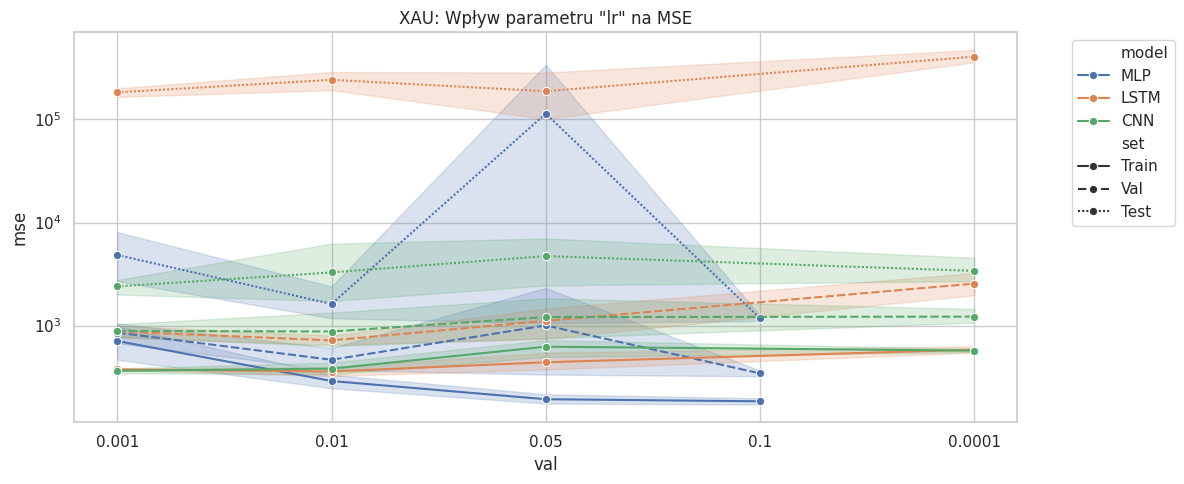

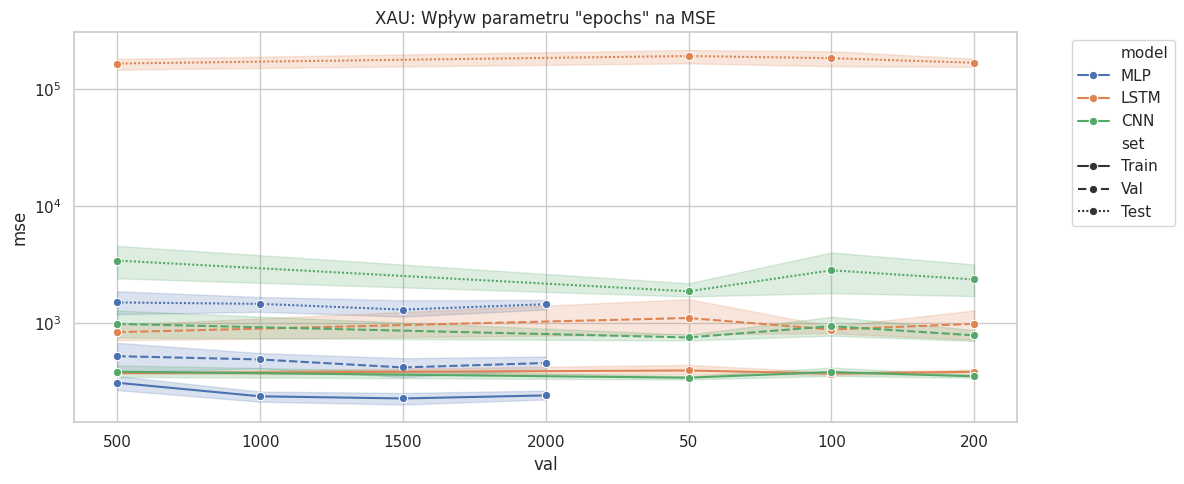

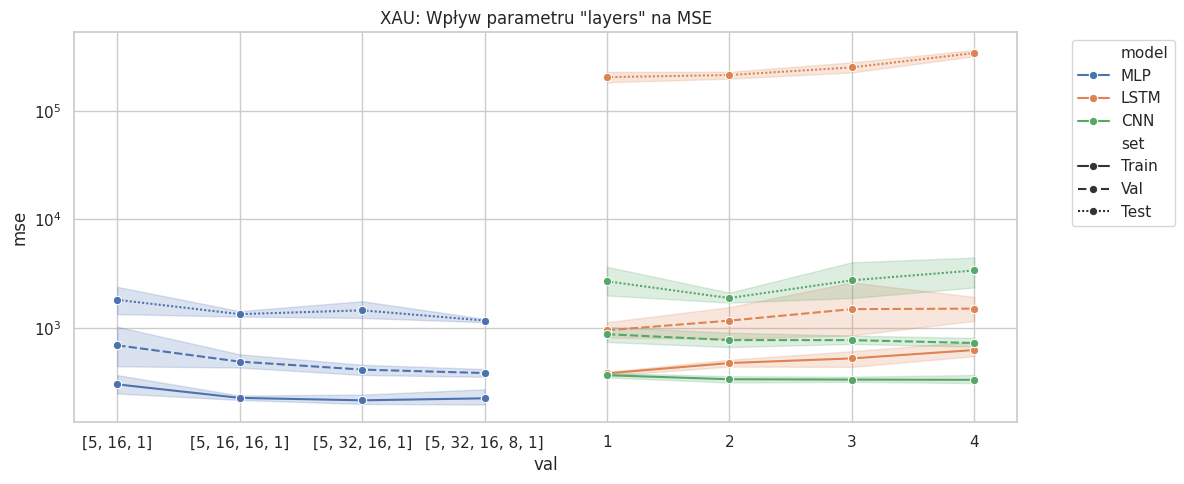

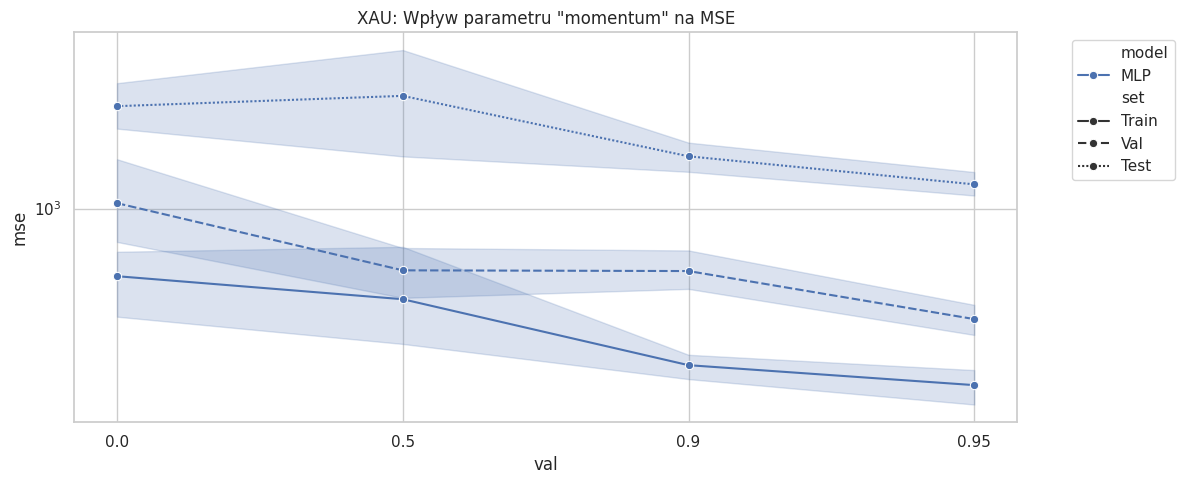

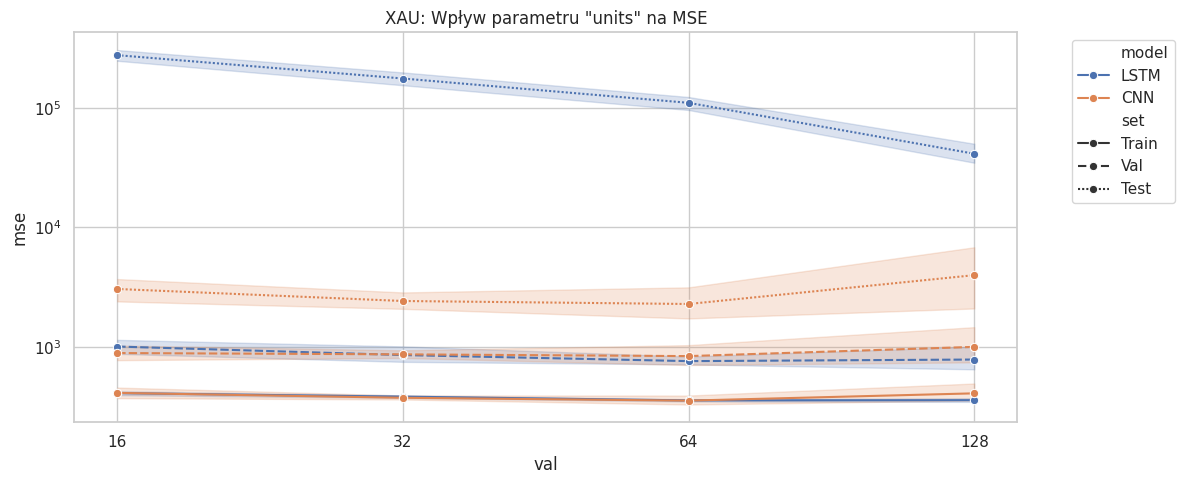

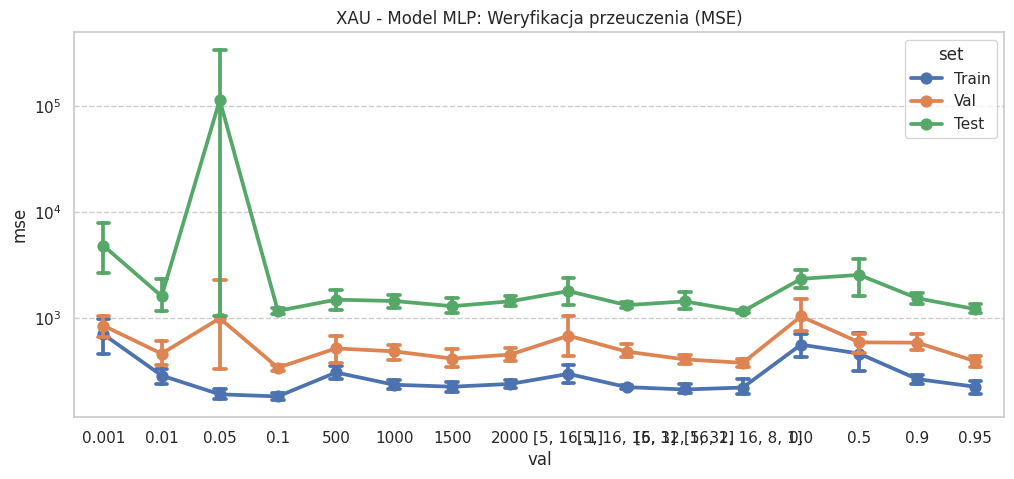

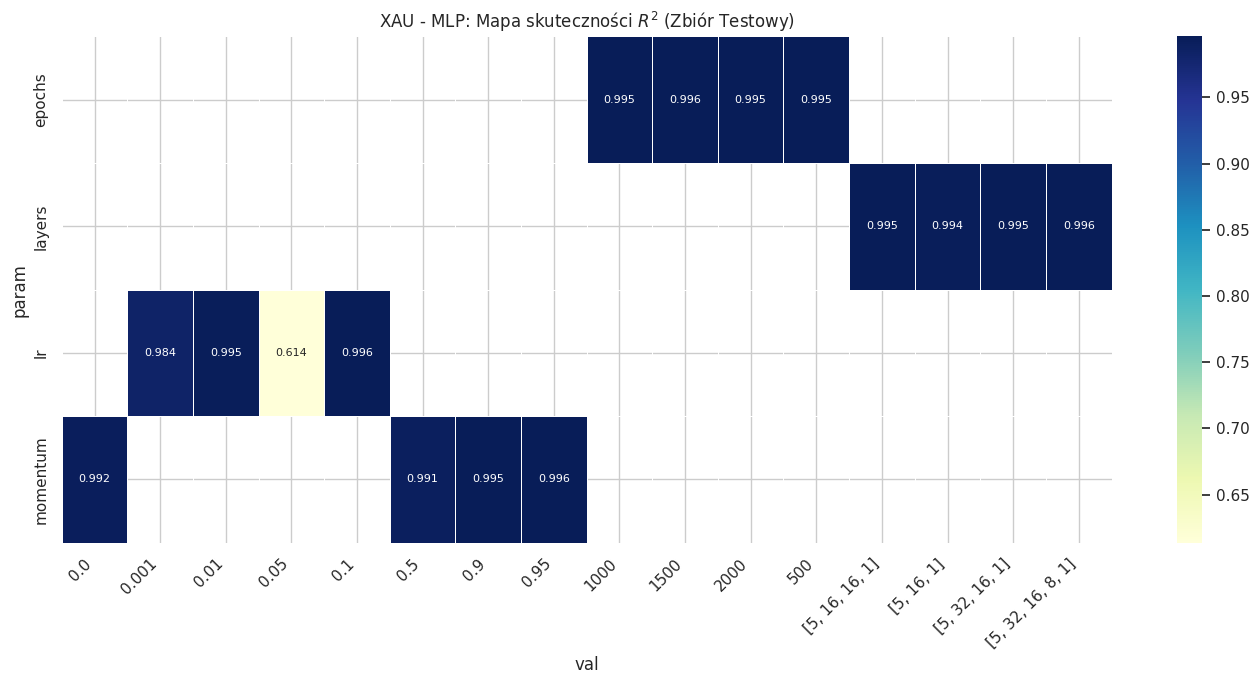

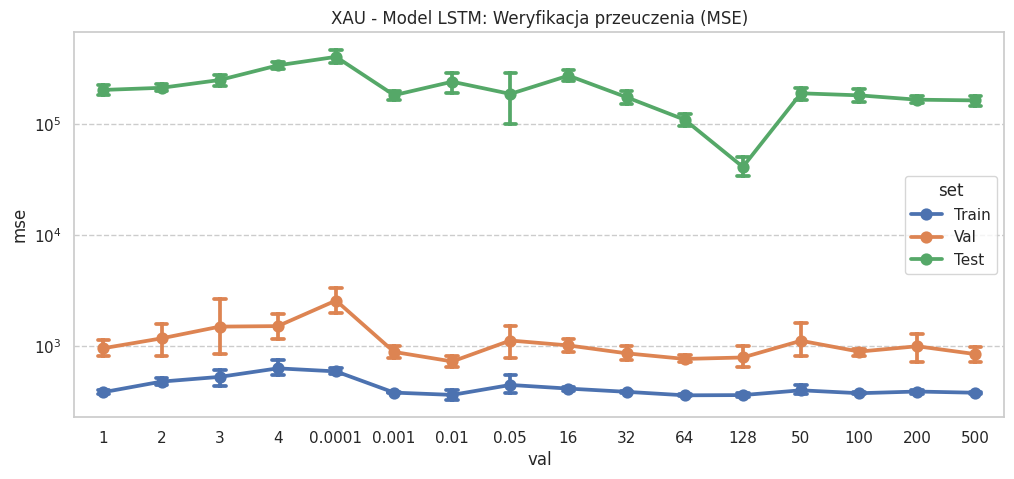

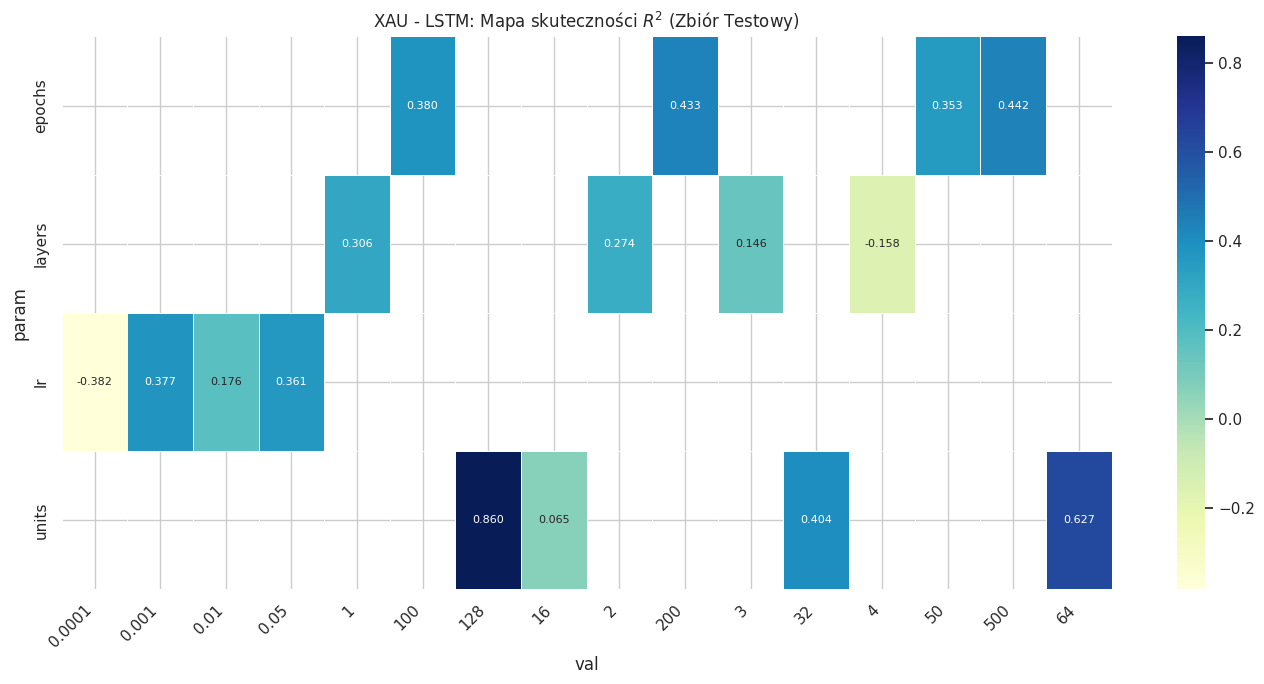

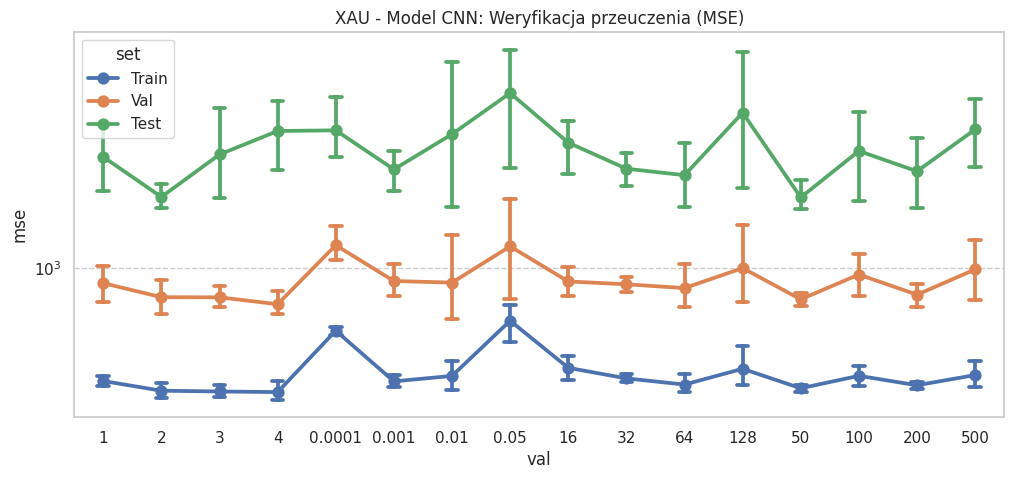

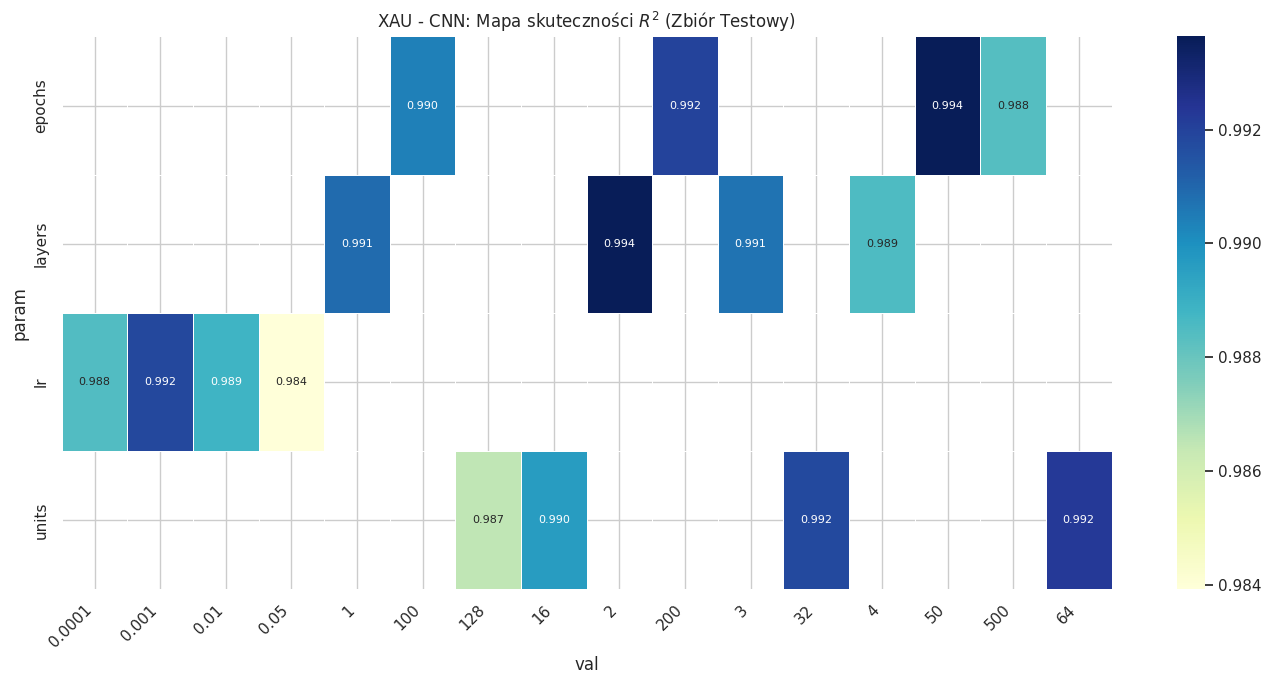

In [ ]:
# Przygotowanie danych do wykresów
df_plot = df_all.copy()
df_plot["set"] = df_plot["set"].str.capitalize()

# 1. ANALIZA WPŁYWU PARAMETRÓW (MSE) - Wykresy liniowe
params_to_plot = df_plot["param"].unique()

print("Generowanie wykresów wpływu parametrów...")
for p in params_to_plot:
    plt.figure(figsize=(12, 5))
    subset_df = df_plot[df_plot["param"] == p]

    # Sortowanie osi X, jeśli to liczby
    try:
        subset_df["val_num"] = pd.to_numeric(subset_df["val"])
        subset_df = subset_df.sort_values("val_num")
    except:
        pass

    sns.lineplot(
        data=subset_df,
        x="val",
        y="mse",
        hue="model",
        style="set",
        markers=True,
        dashes=True,
        err_style="band",  # Pokazuje przedział ufności (odchylenie standardowe)
    )
    plt.title(f'XAU: Wpływ parametru "{p}" na MSE (skala logarytmiczna)')
    plt.yscale("log")  # Skala logarytmiczna dla lepszej czytelności błędów
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# 2. HEATMAPY R2 (Dla zbioru testowego)
print("Generowanie map ciepła (Heatmaps)...")
for model_name in df_plot["model"].unique():
    test_data = df_plot[(df_plot["model"] == model_name) & (df_plot["set"] == "Test")]

    if not test_data.empty:
        # Pivot table: wiersze=parametr, kolumny=wartość, wartości=R2
        pivot_data = test_data.pivot_table(index="param", columns="val", values="r2")

        if not pivot_data.empty:
            fig, ax = plt.subplots(figsize=(14, 6))
            sns.heatmap(
                pivot_data,
                annot=True,
                cmap="RdYlGn",  # Czerwony=Słabo, Zielony=Dobrze
                fmt=".3f",
                linewidths=1,
                linecolor="white",
                cbar_kws={"label": "R² Score"},
                ax=ax,
            )
            plt.title(f"XAU - {model_name}: Mapa skuteczności $R^2$ (Zbiór Testowy)")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.show()

In [ ]:
# --- 1. TRENOWANIE NAJLEPSZEGO MODELU (z Optuny) DO ANALIZY RESZT ---
print("Trenowanie najlepszego modelu LSTM do analizy reszt...")

best_model = Sequential()
best_model.add(Input(shape=(TIME_STEPS, X_train_seq.shape[2])))

# Odtworzenie modelu z najlepszych parametrów Optuny
n_layers = best_params.get("n_layers", 2)
n_units = best_params.get("n_units", 64)
dropout_rate = best_params.get("dropout", 0.0)

for i in range(n_layers):
    best_model.add(LSTM(n_units, return_sequences=(i < n_layers - 1)))
    if dropout_rate > 0:
        best_model.add(Dropout(dropout_rate))

best_model.add(Dense(1))
best_model.compile(
    optimizer=Adam(learning_rate=best_params.get("lr", 0.001)), loss="mse"
)

best_model.fit(X_train_seq, y_train_seq, epochs=50, batch_size=64, verbose=0)

# Predykcje na zbiorze testowym
y_pred_scaled = best_model.predict(X_test_seq, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_true = scaler_y.inverse_transform(y_test_seq)

# Obliczenie reszt (błędów)
residuals = y_true - y_pred

# --- WYKRESY RESZT ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Histogram reszt
sns.histplot(residuals, kde=True, ax=axes[0], color="blue")
axes[0].set_title("Rozkład Reszt (Błędów)")
axes[0].set_xlabel("Błąd (Rzeczywiste - Przewidziane)")
axes[0].axvline(0, color="red", linestyle="--")  # Linia idealnego zera

# Wykres rozrzutu: Predykcja vs Reszty
axes[1].scatter(y_pred, residuals, alpha=0.5)
axes[1].axhline(0, color="red", linestyle="--")
axes[1].set_title("Wykres Homoskedastyczności (Predykcje vs Reszty)")
axes[1].set_xlabel("Wartość Przewidziana")
axes[1].set_ylabel("Reszta")

plt.tight_layout()
plt.show()

# --- 2. GENEROWANIE TABELI PODSUMOWUJĄCEJ DLA SPRAWOZDANIA ---
# Agregacja wyników: Średnia, Odchylenie Std, Max
summary_table = df_all.groupby(["model", "param", "val", "set"])[
    ["mse", "mae", "r2"]
].agg(["mean", "std", "max"])

# Zaokrąglanie dla czytelności
summary_table = summary_table.round(4)

# Zapis do Excela (do wklejenia do sprawozdania)
file_name = "XAU_Final_Summary_Stats.xlsx"
with pd.ExcelWriter(file_name) as writer:
    summary_table.to_excel(writer, sheet_name="Aggregated Stats")
    df_all.to_excel(writer, sheet_name="Raw Data")

print(f"\n[SUKCES] Wygenerowano tabelę statystyk i zapisano do pliku: {file_name}")
print("Możesz teraz skopiować tabelę z Excela prosto do sprawozdania.")